In [7]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

from tqdm import tqdm

import tensorflow as tf

2023-03-13 21:21:07.590912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 21:21:10.517718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-13 21:21:10.518768: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or di

In [10]:
# train.csv file
df = pd.read_csv(f"../data/train.csv")
df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [11]:
len(df)

94477

In [12]:
files = glob(f"../data/train_landmark_files/*/*")

In [13]:
len(files)

94477

Number of rows in the `train.csv` file is equal to the number of parquet files.

In [14]:
df.participant_id.value_counts()

49445    4968
61333    4900
36257    4896
16069    4848
26734    4841
55372    4826
2044     4810
37779    4782
32319    4753
29302    4722
22343    4677
53618    4656
37055    4648
28656    4563
62590    4563
34503    4545
27610    4275
25571    3865
18796    3502
4718     3499
30680    3338
Name: participant_id, dtype: int64

In [15]:
df.sequence_id.value_counts()

1000035562    1
3581948762    1
3582491179    1
3582420976    1
3582370385    1
             ..
2290034600    1
2290026468    1
2289951796    1
2289904716    1
999962374     1
Name: sequence_id, Length: 94477, dtype: int64

<AxesSubplot:>

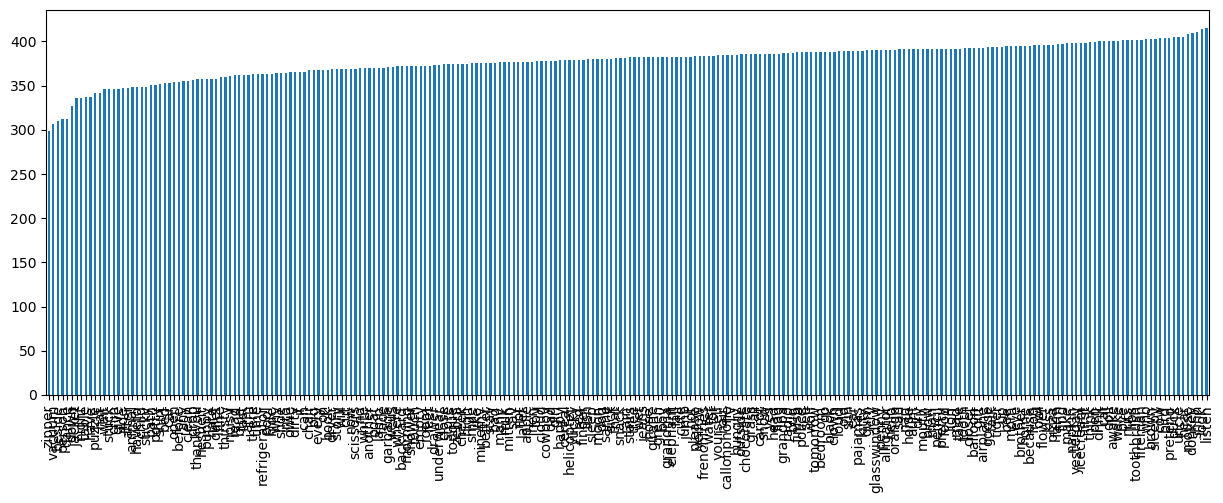

In [16]:
plt.figure(figsize=(15,5))
df.sign.value_counts().sort_values().plot(kind = 'bar')

The class distribution doesn't look scary.

In [17]:
file_path = files[0]
file_path

'../data/train_landmark_files/62590/3752232128.parquet'

In [18]:
landmark_df = pd.read_parquet(file_path)
landmark_df

,frame,row_id,type,landmark_index,x,y,z
0,24,24-face-0,face,0,0.482519,0.541322,-0.039893
1,24,24-face-1,face,1,0.472760,0.512788,-0.056439
2,24,24-face-2,face,2,0.477379,0.523175,-0.033472
3,24,24-face-3,face,3,0.464865,0.489247,-0.033365
4,24,24-face-4,face,4,0.471900,0.504763,-0.058107
...,...,...,...,...,...,...,...
15199,51,51-right_hand-16,right_hand,16,0.255574,0.667270,-0.052585
15200,51,51-right_hand-17,right_hand,17,0.140876,0.630376,-0.044099
15201,51,51-right_hand-18,right_hand,18,0.199194,0.656976,-0.061003
15202,51,51-right_hand-19,right_hand,19,0.213746,0.675306,-0.058339


In [19]:
landmark_df.type.value_counts()

face          13104
pose            924
left_hand       588
right_hand      588
Name: type, dtype: int64

In [16]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

n_frames = int(len(landmark_df) / ROWS_PER_FRAME)
n_frames

46

In [17]:
frame_df = landmark_df.groupby("frame")

In [20]:
for frame, tmp_df in frame_df:
    break

In [23]:
tmp_df.type.value_counts()

face          468
pose           33
left_hand      21
right_hand     21
Name: type, dtype: int64

* "hand landmark model performs precise keypoint localization of 21 3D hand-knuckle coordinates" ([Source](https://google.github.io/mediapipe/solutions/hands.html#hand-landmark-model))

* "MediaPipe Pose is a ML solution for high-fidelity body pose tracking, inferring 33 3D landmarks" ([Source](https://google.github.io/mediapipe/solutions/pose.html))

* "MediaPipe Face Mesh is a solution that estimates 468 3D face landmarks in real-time even on mobile devices." ([source](https://google.github.io/mediapipe/solutions/face_mesh.html))


For each parquet, there are N frames. Each frame is represented by normalized (x, y, z) values of size 543. The representation is landmarks of face, left hand, body pose and right hand in that order as predicted by MediaPipe pipeline.

Each data point can be represented as (N, 543, x, y, z). We can also include `landmark_index` and `type` in the modeling process. Note that we can ignore `z` since the MediaPipe model is not well trained for depth estimation.

Each parquet file maps to a single class (250 classes in total).

Ideas:

* Model it sequentially. LSTMs can be used but how? How to design the data pipeline? 
* Have a linear head on top with classification loss to optimize for.
* Stratified train test split (label = `sign`)

In [27]:
# Number of frames - stats

frames = []

for file_path in tqdm(files):
    landmark_df = pd.read_parquet(file_path)
    n_frames = int(len(landmark_df) / ROWS_PER_FRAME)
    frames.append(n_frames)
    
frames = np.array(frames)

100%|██████████| 94477/94477 [40:33<00:00, 38.83it/s]  


In [34]:
frames.mean(), frames.std(), frames.min(), frames.max(), np.median(frames)

(37.93502122209638, 44.1768352150635, 2, 537, 22.0)

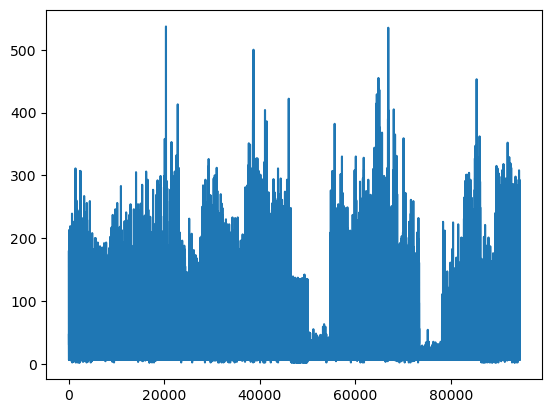

In [35]:
plt.plot(frames)

In [39]:
np.where(frames == 2)

(array([  700,  1425,  1757,  2087,  2123,  2296,  3713,  4573,  9457,
        16810, 16912, 17415, 17834, 23528, 25827, 28511, 29691, 31264,
        31481, 32006, 32389, 33523, 33805, 34726, 38600, 40054, 40778,
        40934, 41117, 42301, 43821, 46634, 46718, 46840, 46841, 47063,
        47075, 47087, 47090, 47173, 47184, 47237, 47282, 47546, 47618,
        47688, 47846, 47915, 47983, 48012, 48105, 48148, 48187, 48326,
        48350, 48365, 48443, 48591, 48673, 48998, 49016, 49137, 49292,
        49410, 49549, 49585, 49662, 49688, 49702, 49726, 49741, 49831,
        49842, 53954, 59088, 61080, 61553, 61830, 69260, 70359, 71220,
        71562, 73156, 86464, 86718, 86896, 87038, 87236, 87252, 87628,
        88120, 88436, 88676, 88778, 89279, 89434, 89570, 89978, 92846,
        93338, 93385, 93682, 93994]),)

In [30]:
a = pd.read_parquet(files[1425])
a

,frame,row_id,type,landmark_index,x,y,z
0,21,21-face-0,face,0,0.502132,0.433712,-0.050234
1,21,21-face-1,face,1,0.497779,0.403526,-0.053531
2,21,21-face-2,face,2,0.500220,0.418760,-0.038020
3,21,21-face-3,face,3,0.491329,0.387557,-0.023633
4,21,21-face-4,face,4,0.497636,0.396389,-0.052261
...,...,...,...,...,...,...,...
7054,33,33-right_hand-16,right_hand,16,0.455577,0.462523,-0.104674
7055,33,33-right_hand-17,right_hand,17,0.434701,0.653933,-0.084370
7056,33,33-right_hand-18,right_hand,18,0.463904,0.589026,-0.100747
7057,33,33-right_hand-19,right_hand,19,0.477269,0.550385,-0.102713


In [37]:
a.type.value_counts()

face          6084
pose           429
left_hand      273
right_hand     273
Name: type, dtype: int64

In [40]:
xyz = a[["x", "y", "z"]].values
xyz

array([[ 0.50213224,  0.43371201, -0.05023378],
       [ 0.49777859,  0.40352583, -0.05353121],
       [ 0.50022024,  0.41876009, -0.03801953],
       ...,
       [ 0.46390405,  0.58902556, -0.10074738],
       [ 0.47726858,  0.55038512, -0.10271256],
       [ 0.48607022,  0.51715976, -0.10211676]])

In [42]:
len(a) / 543

2.0

In [47]:
df["num_frames"] = frames

In [48]:
df

,path,participant_id,sequence_id,sign,num_frames
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,46
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,6
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,20
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,20
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,180
...,...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white,6
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have,23
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower,121
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room,21


In [49]:
import wandb
wandb.__version__

'0.13.10'

In [50]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [51]:
run = wandb.init(project="asl_sign")
wandb.log({"train.csv": wandb.Table(dataframe=df)})
run.finish()

wandb: Currently logged in as: ayush-thakur. Use `wandb login --relogin` to force relogin


# Extended CSV

Ref: https://www.kaggle.com/datasets/dschettler8845/gislr-extended-train-dataframe

In [21]:
df = pd.read_csv("../data/extended_train.csv")

In [22]:
len(df)

94477

In [23]:
df.columns

Index(['path', 'participant_id', 'sequence_id', 'sign', 'start_frame',
       'end_frame', 'total_frames', 'face_count', 'face_nan_count',
       'pose_count', 'pose_nan_count', 'left_hand_count',
       'left_hand_nan_count', 'right_hand_count', 'right_hand_nan_count',
       'x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max'],
      dtype='object')

In [24]:
df

,path,participant_id,sequence_id,sign,start_frame,end_frame,total_frames,face_count,face_nan_count,pose_count,...,left_hand_count,left_hand_nan_count,right_hand_count,right_hand_nan_count,x_min,x_max,y_min,y_max,z_min,z_max
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow,20,42,23,10764,0,759,...,483,483,483,252,-0.031811,1.294350,-2.147826,-0.224151,-2.782624,1.910815
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait,29,39,11,5148,0,363,...,231,231,231,189,-0.017062,1.015931,-2.222732,-0.329273,-2.543970,1.627621
2,/kaggle/input/asl-signs/train_landmark_files/1...,16069,100015657,cloud,103,207,105,49140,0,3465,...,2205,1617,2205,2205,-0.042923,1.197836,-2.591290,-0.248094,-2.838325,1.587503
3,/kaggle/input/asl-signs/train_landmark_files/2...,25571,1000210073,bird,17,28,12,5616,0,396,...,252,252,252,0,-0.129268,1.156573,-2.294936,-0.310272,-3.018237,2.196296
4,/kaggle/input/asl-signs/train_landmark_files/6...,62590,1000240708,owie,22,39,18,8424,0,594,...,378,378,378,0,0.072425,1.165405,-2.264609,-0.405282,-2.970331,1.360011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,/kaggle/input/asl-signs/train_landmark_files/5...,53618,999786174,white,64,112,49,22932,0,1617,...,1029,1029,1029,546,0.031721,1.183957,-2.561170,-0.297828,-3.287074,2.400607
94473,/kaggle/input/asl-signs/train_landmark_files/2...,26734,999799849,have,36,41,6,2808,0,198,...,126,126,126,84,-0.149159,1.310044,-2.170514,-0.177696,-2.678213,1.494088
94474,/kaggle/input/asl-signs/train_landmark_files/2...,25571,999833418,flower,1,37,37,17316,0,1221,...,777,777,777,294,0.057847,0.977379,-2.460778,-0.223186,-3.220553,2.083376
94475,/kaggle/input/asl-signs/train_landmark_files/2...,29302,999895257,room,9,42,34,15912,0,1122,...,714,714,714,588,-0.045806,0.985802,-2.081611,-0.325751,-2.036529,2.350194


In [25]:
df.pose_nan_count.value_counts()

0    94477
Name: pose_nan_count, dtype: int64

In [26]:
df.right_hand_nan_count.value_counts()

0       11452
126      5087
21       4337
105      4139
42       4064
        ...  
6657        1
5691        1
7665        1
6342        1
8694        1
Name: right_hand_nan_count, Length: 340, dtype: int64

In [27]:
df.left_hand_nan_count.value_counts()

126     9474
0       6929
21      2707
105     2536
231     2534
        ... 
5691       1
7371       1
6720       1
8484       1
5943       1
Name: left_hand_nan_count, Length: 324, dtype: int64

In [28]:
df.face_nan_count.value_counts()

0        90041
468       1423
936        732
1404       497
1872       357
         ...  
35568        1
58968        1
55692        1
27612        1
31356        1
Name: face_nan_count, Length: 71, dtype: int64

> No NaN pose. Will that be the case for test set too?

Face, Pose, Left Hand, Right Hand

Face and especially Pose is going to be fixed somewhat

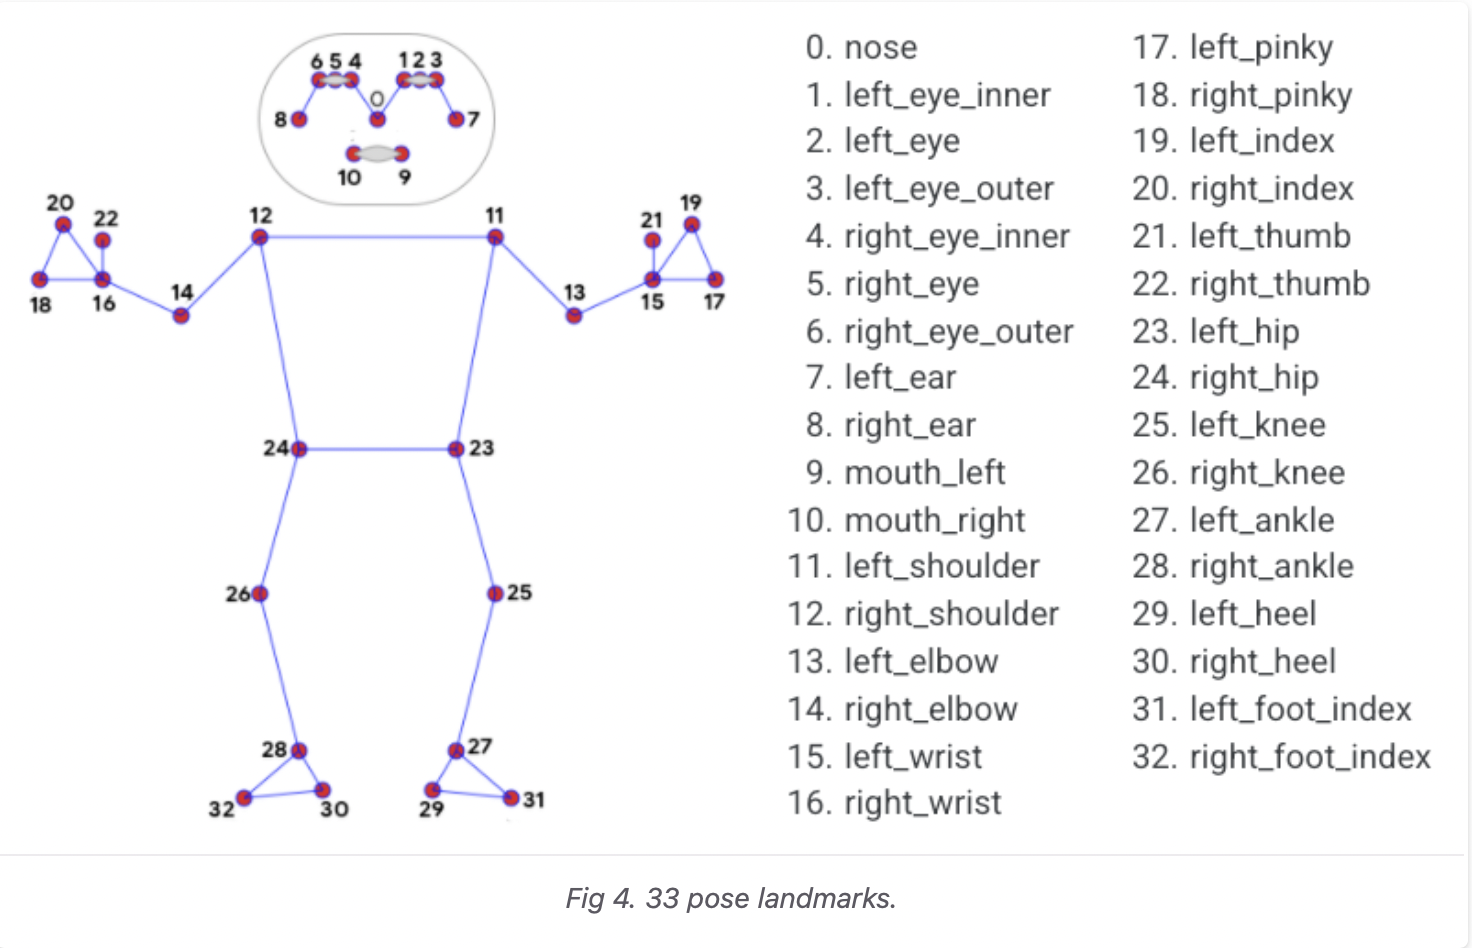

In [ ]:
LEFT_HIP = 23
RIGHT_HIP = 24
LEFT_SHOULDER = 11
RIGHT_SHOULDER = 12

In [ ]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding